In [1]:
# Config
rerun = True
nodes = "8:11"
n_nodes = 16
#nodes = None
nofPn = 4

o_rn = 8
o_rn_gn = 8
n_rn = nofPn


N_fft = 1024
N_beamlet = 488
N_beamset = 2
N_pol = 2
N_pol_bf = 2
P_pfb = 6
S_pn = 2 * P_pfb

N_sub        = 512
sample_freq  = 200000000
N_sample     = 2 * N_sub
shift_freq   = 0.5 * ((sample_freq/2 ) / N_sub) # half a subband
N_blocks     = 64 # Also number of channels per subband

c_subband = 80
c_half_subband = 60.5

c_unit_bf_weight = 2**14
c_beamlet_scale = 1.0 / 2.0**9 # 1.0 / 2.0**9 
c_wg_latency = 10.0 # clock cycles
c_half_subband_phase_offset = 360.0 * c_wg_latency * c_half_subband / N_fft
c_subband_phase_offset = 360.0 * c_wg_latency * c_subband / N_fft
    
c_wg_sp_ampl = 0.5
c_wg_sp_phase = 0.0 + c_subband_phase_offset
c_wg_sp_phase_h = 0.0 + c_half_subband_phase_offset



In [2]:
import time
import collections
import numpy as np
import logging
import sys

sys.path.append('../py')
print(f"{sys.path}")
import base
import control

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("main")

client = base.OpcuaClient("10.99.0.252", 4840)
client.connect()

nodelist = base.arg_str_to_list(nodes) if nodes else None
if nodelist is None:
    nodelist = client.node_list  # if no --nodes in arguments select all
client.set_mask(nodelist)  # write fpga_mask for write actions
print("fpga mask={}".format(client.get_mask()))  # read back nodes set.




['/home/walle/git/sdptr/test/notebooks', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/walle/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/walle/.ipython', '../py']


INFO:main.opcua:Connected to OPCua server add 10.99.0.252:4840
INFO:asyncua.client.client:connect
INFO:asyncua.client.ua_client.UaClient:opening connection
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.client:Requested secure channel timeout to be 3600000ms, got 600000ms instead
INFO:asyncua.client.ua_client.UaClient:create_session
INFO:asyncua.client.client:find_endpoint [EndpointDescription(EndpointUrl='opc.tcp://10.99.0.252:4840/', Server=ApplicationDescription(ApplicationUri='urn:open62541.server.application', ProductUri='http://open62541.org', ApplicationName=LocalizedText(Locale='en', Text='open62541-based OPC UA Application'), ApplicationType_=<ApplicationType.Server: 0>, GatewayServerUri=None, DiscoveryProfileUri=None, DiscoveryUrls=None), ServerCertificate=None, SecurityMode=<MessageSecurityMode.None_: 1>, SecurityPolicyUri='http://opcfoundation.org/UA/SecurityPolicy#None', UserIdentityTokens=[UserTokenPolicy(PolicyId='open62541-anonymo

fpga mask=[False, False, False, False, False, False, False, False, True, True, True, True, False, False, False, False]


In [3]:
#-------------
# Setup
#-------------
if not rerun:
    # Write RING configuration
    client.write("ring_nof_nodes", ([n_rn] * n_nodes))
    client.write("ring_node_offset", ([o_rn_gn] * n_nodes))

    cable_to_prev = [False] * n_nodes
    cable_to_next = [False] * n_nodes
    for gn in range(o_rn, n_rn + o_rn):
        cable_to_prev[(gn % nofPn == 0)]
        cable_to_next[(gn % nofPn == 3)]
    cable_to_prev[o_rn] = True # First RN
    cable_to_next[o_rn + n_rn - 1] = True # Last RN
    client.write("ring_use_cable_to_previous_rn", cable_to_prev)
    client.write("ring_use_cable_to_next_rn", cable_to_next)
    print(cable_to_next)

    nof_hops = [0] * N_beamset * n_nodes
    for i in range(o_rn, o_rn + n_rn - 1):
        nof_hops[N_beamset * i] = 1
        nof_hops[N_beamset * i + 1] = 1
    #nof_hops[N_beamset * o_rn + n_rn - 1] = 0 # Last RN
    #nof_hops = np.array([[i, i] for i in nof_hops]).flatten()
    #nof_hops = nof_hops + nof_hops # repeat for second beamset
    print(nof_hops)
    client.write("bf_ring_nof_transport_hops", nof_hops)

    # Disable spectral inversion
    client.write("subband_spectral_inversion", ([False] * n_nodes))


    # Write unit weights to subband weights (no correction)
    unit_sub_gains = [2**13] * N_beamset * N_fft * P_pfb * n_nodes
    client.write("subband_weights", (unit_sub_gains))

    # Write unit weights to beamlet weights
    unit_bf_weights = [2**14] * N_beamlet * N_pol_bf * S_pn * N_beamset * n_nodes 
    client.write("bf_weights", unit_bf_weights)

    # Write beamlet selects in order (i.e. 0, 1, 2, 3, .... 487)
    beamlet_selects = list(np.arange(0,N_beamlet)) * N_pol_bf * N_beamset * n_nodes * P_pfb
    client.write("beamlet_subband_select", beamlet_selects)





In [4]:
# Enable processing
if not rerun:
    client.write("processing_enable", ([False]*16))
    time.sleep(2)
    client.write("processing_enable", ([True]*16))
    time.sleep(3) # Wait long enough for FPGA's to startup
    print(client.read("processing_enable"))


In [5]:

# Set beamlet output scale
client.write("beamlet_output_scale", ([c_beamlet_scale] * n_nodes * N_beamset))

# WG configuration
wg_ampl = [c_wg_sp_ampl] * S_pn * n_nodes
wg_freq = [200*10**6 * (c_subband/N_fft)] * S_pn * n_nodes
wg_phase = [np.deg2rad(c_wg_sp_phase)] * S_pn * n_nodes

wg_freq[o_rn * S_pn] = 200*10**6 * (c_half_subband/N_fft)
wg_phase[o_rn * S_pn] = np.deg2rad(c_wg_sp_phase_h)

wg_enable = [False] * n_nodes * S_pn
client.write("wg_enable", wg_enable)
wg_enable[o_rn * S_pn: o_rn * S_pn + 2] = [True] * 2

client.write("wg_amplitude", wg_ampl)
client.write("wg_frequency", wg_freq)
client.write("wg_phase", wg_phase)
client.write("wg_enable", wg_enable)
time.sleep(3)

In [12]:
# Setup UDP receiver and capture packets
beamlet_stream = control.BeamletStream(client, "90:e2:ba:7a:a9:64", "192.168.2.249", "B_488", logger)
beamlet_stream.udp_port = 5005
beamlet_stream.setup_stream()
beamlet_stream.stream_on()
beamlet_stream.start_stream_reader()

packets = []
i = 0
while i < (N_blocks +10):
    if beamlet_stream.stream_packet:
        packets.append(beamlet_stream.stream_reader.queue.get())
        i = i + 1

beamlet_stream.stop_stream_reader()
time.sleep(5)
beamlet_stream.stream_off()



INFO:UDP-Server:udp server opened
INFO:UDP-Server:udp server closed


In [13]:
bmlt_even = []
bmlt_shft_even = []
bmlt_odd = []
bmlt_shft_odd = []
bmlt = []
bmlt_shft = []
for p in packets:
    beamlet_stream.stream_packet.unpack_packet(p)
    beamlet_index = beamlet_stream.stream_packet.header().beamlet_index
    bsn = beamlet_stream.stream_packet.header().beamlet_index
    if beamlet_index == 0:        
        bmlt.append(beamlet_stream.stream_packet.data().beamlets)
    else:
        bmlt_shft.append(beamlet_stream.stream_packet.data().beamlets)

# We take N_channel samples ( = N_channel / 2 packets) Each packet contains 4 blocks, each block has X/Y
bmlt = bmlt[:(N_blocks // 2)]
bmlt_shft = bmlt_shft[:N_blocks // 2]


# Split X bf_pol, X and Y are identical in this testcase
bmlt_x = [[b[2*i] for i in range(0, len(b) // 2)] for b in bmlt]
bmlt_shft_x = [[b[2*i] for i in range(0, len(b) // 2)] for b in bmlt_shft]

# split the 2 blocks per packet in order
bmlt_x = [ b[ i * N_beamlet : (i+1) * N_beamlet] for b in bmlt_x for i in range(2) ]
bmlt_shft_x = [ b[ i * N_beamlet : (i+1) * N_beamlet] for b in bmlt_shft_x for i in range(2)]

print(len(bmlt))

# FFT of every block

sprT = np.transpose(np.array(bmlt_x)) # transpose
# FFT of every subband, creating channels.
spr_ch = np.array([np.fft.fftshift(np.fft.fft(band)) for band in sprT]) 

# The same for the shifted subbands
spcT = np.transpose(np.array(bmlt_shft_x))
spc_ch = np.array([np.fft.fftshift(np.fft.fft(band)) for band in spcT])

# Combine the channels.
combined = [0] * N_blocks * N_beamlet
for i in range(N_beamlet):
    # for N_blocks = number of channels per subband = 16
    #0:8 = spr_ch[0][4:12]
    #8:16 = spc_ch[0][4:12]
    #16:24 = spr_ch[1][4:12]
    #24:32 = spc_ch[1][4:12]
    # ...
    n_ch = N_blocks // 2

    combined[ 2 * i      * n_ch :  (2 * i + 1) * n_ch] = spc_ch[i][n_ch // 2 : n_ch + (n_ch // 2)]
    combined[(2 * i + 1) * n_ch :  (2 * i + 2) * n_ch] = spr_ch[i][n_ch // 2 : n_ch + (n_ch // 2)]

# shift 3/4 subband to 0
combined = np.array(combined)
combined = combined[(3 * N_blocks // 4):]
combined = np.append(combined, spc_ch[N_beamlet-1][N_blocks // 4:])

32


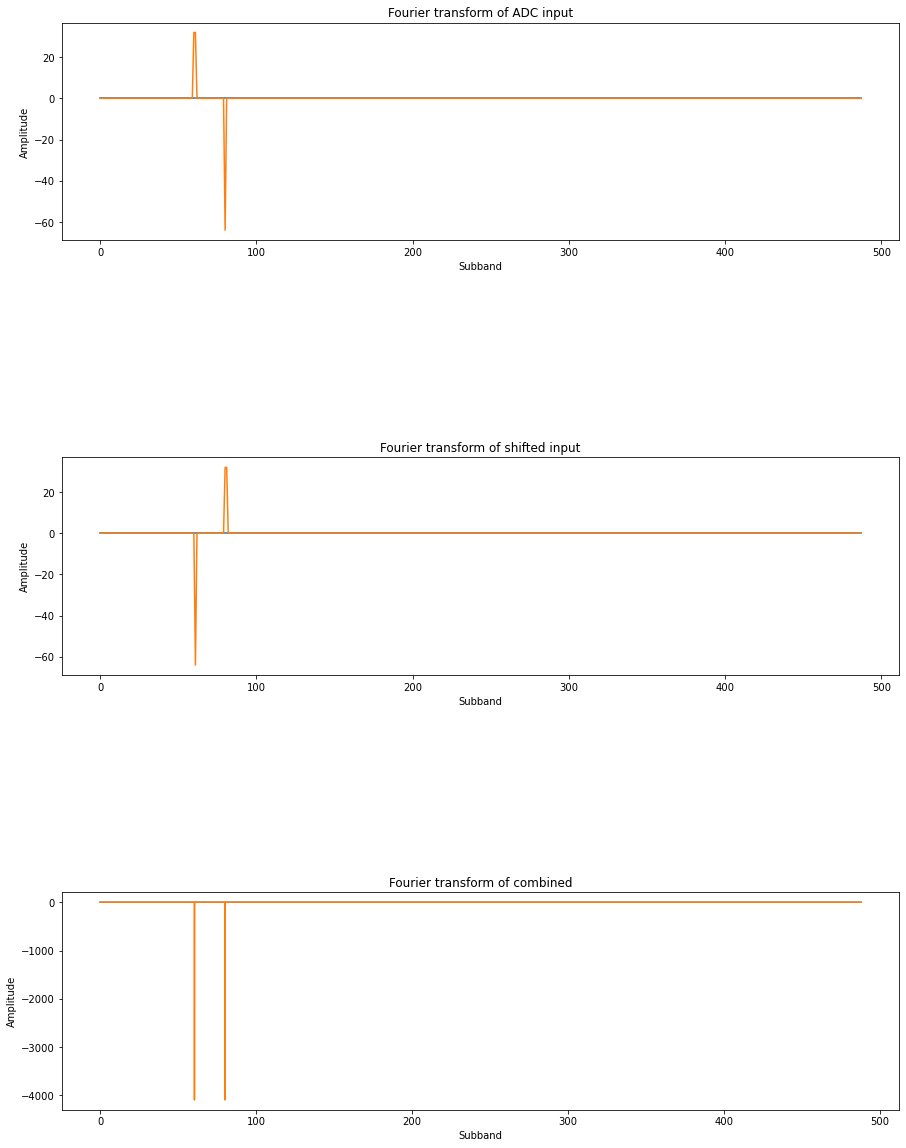

INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_cha

INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_channel
INFO:asyncua.client.ua_client.UASocketProtocol:open_secure_cha

In [14]:
import matplotlib
import matplotlib.pyplot as plt
# Constants


# At what intervals time points are sampled
samplingInterval = 1 / sample_freq;

# Bin indices for input/shifted signal
freq = np.fft.fftfreq(np.arange(N_sample).shape[-1], samplingInterval)
subbands = [f/(shift_freq*2) for f in freq]

# Channel indices.
freq_ch = np.fft.fftfreq(np.arange(N_blocks*N_sample).shape[-1], samplingInterval)
channels = [f/(shift_freq*2) for f in freq_ch]
channels = channels[0:len(channels) // 2:] # Only positive part is used.


# Create subplot
figure, axis = plt.subplots(3, 1, figsize=(15,20))
plt.subplots_adjust(hspace=1)
windowRange = [0, 488]

# Frequency domain representation of input signal
x = subbands[windowRange[0]:windowRange[1]]
y = np.array(bmlt_x)[1][windowRange[0]:windowRange[1]]
axis[0].set_title('Fourier transform of ADC input')
axis[0].plot(x, y.real, x, y.imag)
axis[0].set_xlabel('Subband')
axis[0].set_ylabel('Amplitude')

# Frequency domain representation of frequency shifted signal
x = subbands[windowRange[0]:windowRange[1]]
y = np.array(bmlt_shft_x)[1][windowRange[0]:windowRange[1]]
axis[1].set_title('Fourier transform of shifted input')
axis[1].plot(x, y.real, x, y.imag)
axis[1].set_xlabel('Subband')
axis[1].set_ylabel('Amplitude')

x = channels[N_blocks * windowRange[0]:N_blocks * windowRange[1]]
y = combined[N_blocks * windowRange[0]:N_blocks * windowRange[1]]
# Frequency domain representation of combined channels
axis[2].set_title('Fourier transform of combined')
axis[2].plot(x, y.real, x, y.imag)
axis[2].set_xlabel('Subband')
axis[2].set_ylabel('Amplitude')

plt.show()